<a href="https://colab.research.google.com/github/jemfr02/Final-Team9/blob/main/TMDB_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#revenue, budget = null, 0인 행 필터링(파일 크기 이슈로 VSCODE 통해 진행)

*FILE_PATH 입력 필요

In [ ]:
import pandas as pd

file_path = 'TMDB_movie_dataset_v11.csv'
# 새로 저장할 파일의 이름을 정합니다.
output_file_path = 'filteredTMDB.csv'

# 첫 번째 덩어리인지 확인하기 위한 변수를 만듭니다. (헤더를 한 번만 저장하기 위함)
is_first_chunk = True

# 파일을 10만 행씩 잘라서 순차적으로 처리
chunk_iterator = pd.read_csv(
    file_path,
    chunksize=100000,
    encoding='utf-8',
    low_memory=False
)

print(f"필터링을 시작합니다. 결과는 '{output_file_path}' 파일에 저장됩니다...")

# 각 덩어리(chunk)를 순회하며 조건에 맞는 행을 찾고 저장합니다.
for i, chunk in enumerate(chunk_iterator):
    chunk['budget'] = pd.to_numeric(chunk['budget'], errors='coerce').fillna(0)
    chunk['revenue'] = pd.to_numeric(chunk['revenue'], errors='coerce').fillna(0)

    # --- 핵심 조건 ---
    valid_rows = chunk[(chunk['budget'] != 0)]

    # 찾은 데이터가 있을 경우에만 저장 작업을 수행합니다.
    if not valid_rows.empty:
        if is_first_chunk:
            # 첫 번째 덩어리는 헤더와 함께 새 파일로 저장합니다.
            valid_rows.to_csv(
                output_file_path,
                index=False,
                encoding='utf-8-sig'
            )
            is_first_chunk = False  # 다음부터는 이 코드를 실행하지 않도록 변경
        else:
            # 두 번째 덩어리부터는 헤더 없이 기존 파일에 내용을 추가합니다.
            valid_rows.to_csv(
                output_file_path,
                mode='a',
                header=False,
                index=False,
                encoding='utf-8-sig'
            )

    print(f"{i+1}번째 덩어리 처리 중...")

print("\n--- 작업 완료 ---")
print(f"'{output_file_path}' 파일이 생성되었습니다.")

#TMDB API 크롤링(VSCODE 통해 진행)

*API_KEY, FILE_PATH 입력 필요

In [ ]:
import pandas as pd
import requests
import time
from tqdm import tqdm

# --- 1. API 키 설정 ---
# TMDB에서 발급받은 본인의 API 키를 여기에 입력하세요.
API_KEY = 'API_KEY' # 예: 'a1b2c3d4e5f6a1b2c3d4e5f6a1b2c3d4'

def get_credits(movie_id):
    """
    주어진 movie_id로 감독(Director)과 상위 5명의 배우(Cast) 이름을 찾아 반환하는 함수
    """
    time.sleep(0.05) # API 서버에 부담을 주지 않기 위해 잠시 대기
    url = f"https://api.themoviedb.org/3/movie/{int(movie_id)}/credits?api_key={API_KEY}&language=en-US"

    director = None
    cast = None

    try:
        response = requests.get(url, timeout=10)

        if response.status_code == 200:
            data = response.json()

            # 감독 찾기
            for member in data.get('crew', []):
                if member.get('job') == 'Director':
                    director = member.get('name')
                    break # 첫 번째 감독만 찾고 종료

            # 상위 5명 배우 이름 가져오기
            cast_list = [actor.get('name') for actor in data.get('cast', [])[:5]]
            if cast_list:
                cast = ', '.join(cast_list) # 쉼표로 구분된 텍스트로 변환

        # 찾은 감독과 배우 목록을 반환
        return director, cast

    except requests.exceptions.RequestException:
        # 연결 오류 시 둘 다 에러로 처리
        return "Connection Error", "Connection Error"

def main():
    """메인 실행 함수"""
    if API_KEY == 'YOUR_API_KEY':
        print("\n[오류] 코드의 API_KEY 부분을 본인의 TMDB API 키로 변경한 후 다시 실행해주세요.")
        return

    print("TMDB API를 사용하여 감독 및 배우 정보를 가져오는 작업을 시작합니다.")

    try:
        df = pd.read_csv('FILE_PATH', encoding='utf-8')
        print(f"\n'filteredTMDB.csv' 파일을 성공적으로 읽었습니다. (총 {len(df)}개 행)")
    except FileNotFoundError:
        print("\n[오류] 'filteredTMDB.csv' 파일을 찾을 수 없습니다.")
        return

    # 각 영화 ID에 대해 get_credits 함수를 적용하고 결과를 저장할 리스트
    results = []

    # tqdm을 사용하여 진행 상황 표시
    for movie_id in tqdm(df['id'], desc="감독/배우 정보 가져오는 중"):
        results.append(get_credits(movie_id))

    # 결과를 새로운 컬럼으로 데이터프레임에 추가
    df[['director', 'cast']] = results

    # --- 결과 저장 ---
    output_filename = 'TMDB_with_credits.csv'
    df.to_csv(output_filename, index=False, encoding='utf-8-sig')

    print("\n--- 작업 완료 ---")
    print(f"결과가 '{output_filename}' 파일에 저장되었습니다.")

if __name__ == '__main__':
    main()

#데이터 전처리

- 조건 1: 'backdrop_path', 'homepage', 'poster_path' 컬럼 삭제
- 조건 2: 'vote_count'가 0인 행 삭제
- 조건 3: 'vote_count'가 1이고 'keywords'에 'wrestling'이 포함된 행 삭제
- 조건 4: 'genres', 'production_countries', 'director', 'keywords' 컬럼이 null인 행 삭제
- ROI 및 SR 계산 로직 추가
- 흥행척도(y_result) 컬럼 추가

In [ ]:
import pandas as pd
import os
import numpy as np

# 1. 파일 경로 설정
# 코랩에 직접 파일을 업로드한 경우 이 경로를 사용합니다.
file_path = '/content/TMDB_with_credits.csv'

# 2. CSV 파일 불러오기
try:
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path)
    print("Data loaded successfully. Initial shape:", df.shape)
    print("\nInitial DataFrame info:")
    df.info()
except FileNotFoundError:
    print(f"Error: The file was not found at the specified path: {file_path}")
    print("Please make sure you have uploaded 'TMDB_with_credits.csv' to your Colab session.")
    # 파일이 없을 경우, 이후 코드 실행을 막기 위해 빈 데이터프레임 생성
    df = pd.DataFrame()

# 3. 데이터 가공 (파일이 성공적으로 로드된 경우에만 실행)
if not df.empty:
    # 복사본을 만들어 원본 데이터 보존
    df_processed = df.copy()

    # 조건 1: 'backdrop_path', 'homepage', 'poster_path' 컬럼 삭제
    columns_to_drop = ['backdrop_path', 'homepage', 'poster_path']
    # 해당 컬럼이 데이터프레임에 존재하는지 확인 후 삭제
    existing_columns_to_drop = [col for col in columns_to_drop if col in df_processed.columns]
    if existing_columns_to_drop:
        df_processed.drop(columns=existing_columns_to_drop, inplace=True)
        print(f"\nDropped columns: {existing_columns_to_drop}. Shape after dropping columns:", df_processed.shape)
    else:
        print("\nColumns to drop not found in the DataFrame.")


    # 조건 2: 'vote_count'가 0인 행 삭제
    initial_rows = df_processed.shape[0]
    df_processed = df_processed[df_processed['vote_count'] != 0]
    print(f"\nRemoved rows with vote_count = 0. Shape after filtering:", df_processed.shape)
    print(f"{initial_rows - df_processed.shape[0]} rows were removed.")

    # 조건 3: 'vote_count'가 1이고 'keywords'에 'wrestling'이 포함된 행 삭제
    initial_rows = df_processed.shape[0]
    # 'keywords' 컬럼이 문자열이 아닌 경우(NaN 등) 오류가 발생하지 않도록 astype(str)으로 변환하고,
    # 'wrestling' 문자열을 포함하는지 확인합니다. na=False는 NaN 값을 False로 처리합니다.
    condition_to_remove = (df_processed['vote_count'] == 1) & (df_processed['keywords'].astype(str).str.contains('wrestling', na=False))
    # 위 조건에 해당하지 않는(~) 행들만 선택하여 데이터프레임을 갱신합니다.
    df_processed = df_processed[~condition_to_remove]
    print(f"\nRemoved rows with vote_count = 1 and 'wrestling' in keywords. Shape after filtering:", df_processed.shape)
    print(f"{initial_rows - df_processed.shape[0]} rows were removed.")

    # 조건 4: 'genres', 'production_countries', 'director', 'keywords' 컬럼이 null인 행 삭제
    columns_to_check_null = ['genres', 'production_countries', 'director', 'keywords']
    initial_rows = df_processed.shape[0]
    # 해당 컬럼들이 존재하는지 확인
    existing_columns_to_check = [col for col in columns_to_check_null if col in df_processed.columns]
    if existing_columns_to_check:
        df_processed.dropna(subset=existing_columns_to_check, inplace=True)
        print(f"\nRemoved rows with null values in {existing_columns_to_check}. Final shape:", df_processed.shape)
        print(f"{initial_rows - df_processed.shape[0]} rows were removed.")
    else:
        print("\nColumns to check for nulls not found in the DataFrame.")

    # 조건 5: Budget 30만 달러 미만 행 삭제
    df_processed = df_processed[df_processed['budget'] >= 300000]

    # --- ROI 및 SR 계산 로직 추가 ---

    # 1. ROI(수익률) 계산 컬럼 추가
    df_processed['ROI'] = ((df_processed['revenue'] - df_processed['budget']) / df_processed['budget']) * 100

    # 2. SR(흥행 등급) 계산 컬럼 추가
    conditions = [
        (df_processed['revenue'] / df_processed['budget']) >= 3,
        (df_processed['revenue'] / df_processed['budget']) >= 2.5,
        (df_processed['revenue'] / df_processed['budget']) >= 2,
    ]
    choices = [3, 2, 1]
    df_processed['SR'] = np.select(conditions, choices, default=0)

    # 3. y_result 컬럼 추가
    df_processed['y_result'] = 0

    # ROI 조건
    df_processed['y_result'] = df_processed['y_result'] + np.where(df_processed['ROI'] > 2.5, 1, 0)

    # SR 조건
    df_processed['y_result'] = df_processed['y_result'] + np.where(df_processed['SR'] > 2, 1, 0)

    # 예산 및 매출 조건
    commercial_cond = df_processed['budget'] <= 100000000
    blockbuster_cond = df_processed['budget'] > 100000000

    df_processed['y_result'] = df_processed['y_result'] + np.where(
        commercial_cond & (df_processed['revenue'] >= 100000000), 1, 0)
    df_processed['y_result'] = df_processed['y_result'] + np.where(
        blockbuster_cond & (df_processed['revenue'] >= 500000000), 1, 0)


    # 4. 가공된 데이터 확인
    print("\n--- Processed Data Sample ---")
    print(df_processed.head())

    # 5. 가공된 파일을 새로운 CSV로 저장
    # 원본 파일이 있던 디렉토리에 저장합니다.
    output_directory = os.path.dirname(file_path) if os.path.dirname(file_path) else '/content/'
    output_filename = 'TMDB_processed_final.csv'
    output_path = os.path.join(output_directory, output_filename)

    try:
        df_processed.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f"\nProcessed data successfully saved to: {output_path}")
    except Exception as e:
        print(f"\nAn error occurred while saving the file: {e}")

else:
    print("\nSkipping data processing due to file loading error.")



Loading data from: /content/TMDB_with_credits.csv
Data loaded successfully. Initial shape: (15911, 26)

Initial DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15911 entries, 0 to 15910
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15911 non-null  int64  
 1   title                 15911 non-null  object 
 2   vote_average          15911 non-null  float64
 3   vote_count            15911 non-null  int64  
 4   status                15911 non-null  object 
 5   release_date          13306 non-null  object 
 6   revenue               15911 non-null  int64  
 7   runtime               15911 non-null  int64  
 8   adult                 15911 non-null  bool   
 9   backdrop_path         11156 non-null  object 
 10  budget                15911 non-null  int64  
 11  homepage              4927 non-null   object 
 12  imdb_id               11241 non-null  object

#EDA

In [ ]:
#한글 글씨 폰트 설치

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'


데이터를 로딩 중입니다: /content/TMDB_processed_30up.csv
데이터 로딩이 완료되었습니다. 초기 데이터 크기: (8243, 25)

'vote_average' 및 'popularity' 변수의 기술통계를 확인합니다...
       vote_average   popularity
count   8243.000000  8243.000000
mean       6.438672    22.530479
std        0.872896    67.380934
min        0.800000     0.000000
25%        5.921500     9.837500
50%        6.488000    14.859000
75%        7.029000    22.694500
max       10.000000  2994.357000

'vote_average' 및 'popularity' 분포를 분석합니다...


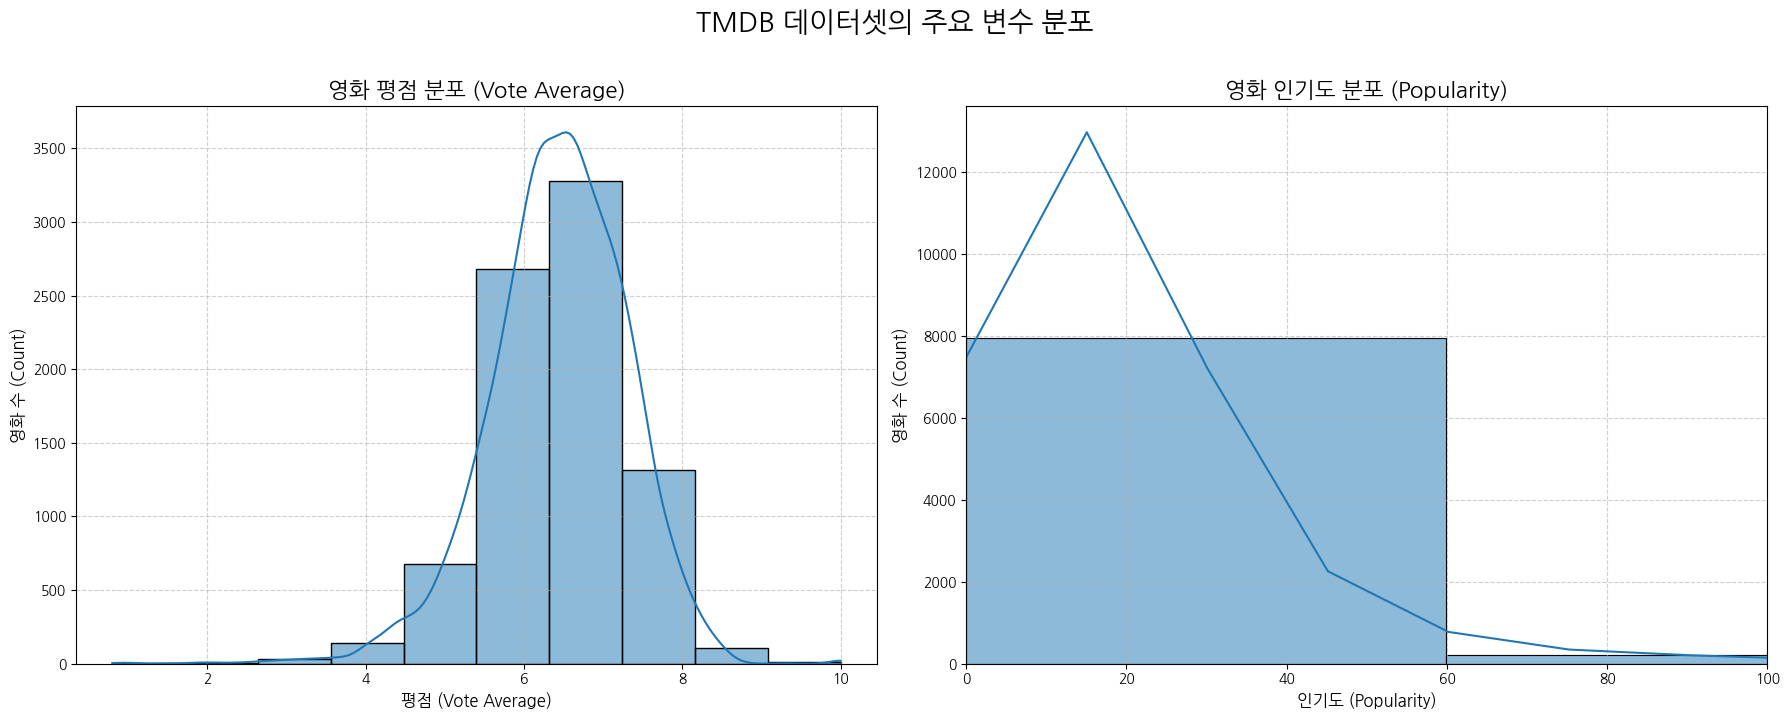


'vote_average' 및 'popularity'의 박스 플롯을 생성합니다...


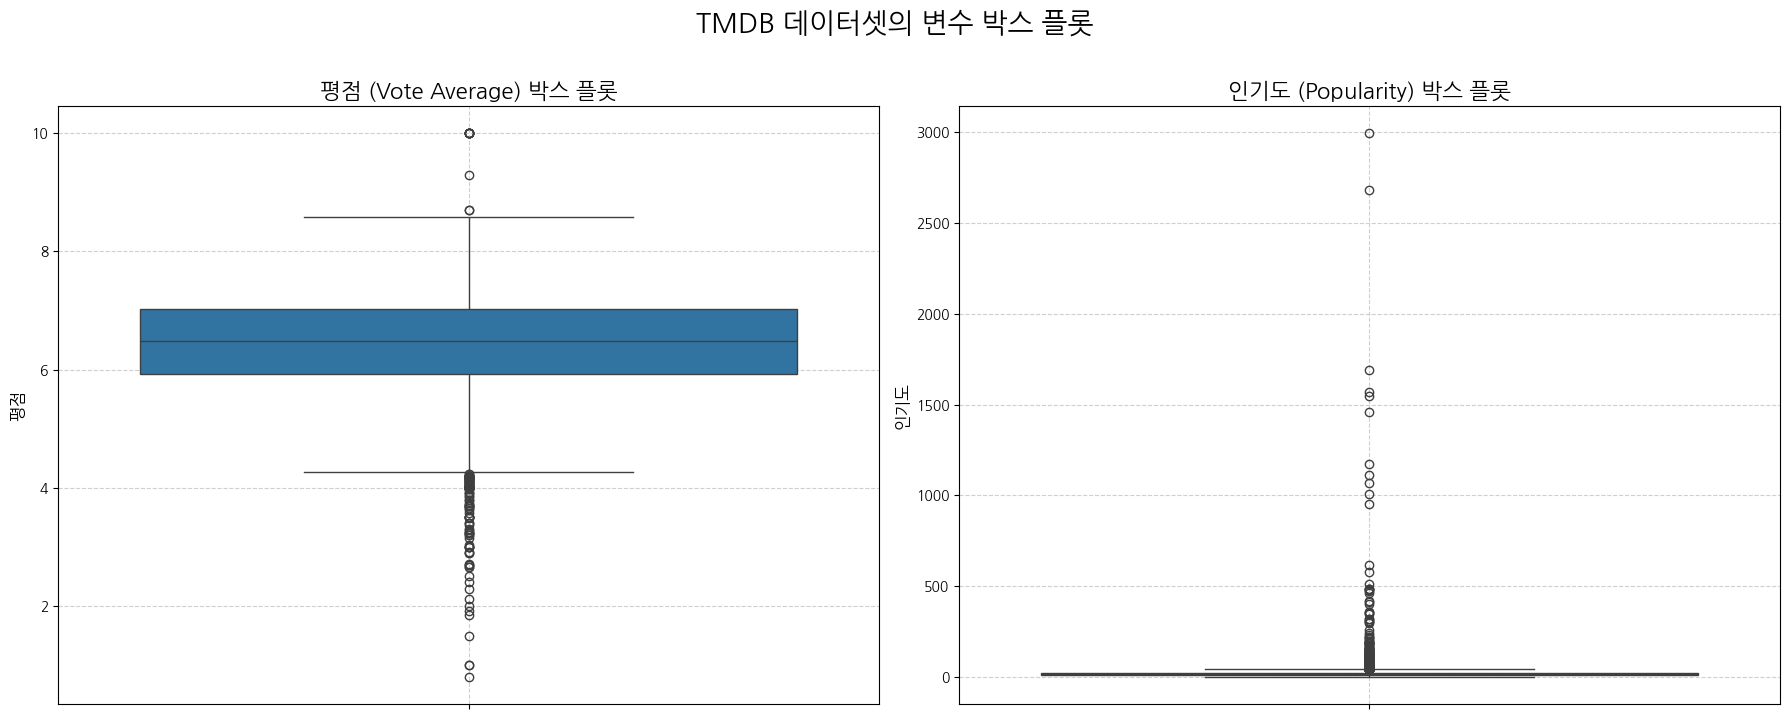

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set the file path
file_path = '/content/TMDB_processed_30up.csv'

# Set font for Korean text in plots
plt.rcParams['font.family'] = 'NanumGothic' # Replace 'NanumGothic' with a font available in your environment if needed
plt.rcParams['axes.unicode_minus'] = False # For displaying minus signs correctly

# Load the CSV file
try:
    print(f"데이터를 로딩 중입니다: {file_path}")
    df = pd.read_csv(file_path)
    print("데이터 로딩이 완료되었습니다. 초기 데이터 크기:", df.shape)
except FileNotFoundError:
    print(f"오류: 파일을 찾을 수 없습니다: {file_path}")
    print("Colab 세션에 'TMDB_with_credits.csv' 파일을 업로드했는지 확인해주세요.")
    df = pd.DataFrame() # Create an empty DataFrame to prevent errors

# Analyze the distributions if data is loaded successfully
if not df.empty:
    print("\n'vote_average' 및 'popularity' 변수의 기술통계를 확인합니다...")
    print(df[['vote_average', 'popularity']].describe())

    print("\n'vote_average' 및 'popularity' 분포를 분석합니다...")

    # Set up a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Plot the distribution of 'vote_average'
    sns.histplot(data=df, x='vote_average', bins=10, kde=True, ax=axes[0])
    axes[0].set_title('영화 평점 분포 (Vote Average)', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('평점 (Vote Average)', fontsize=12)
    axes[0].set_ylabel('영화 수 (Count)', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot the distribution of 'popularity'
    sns.histplot(data=df, x='popularity', bins=50, kde=True, ax=axes[1])
    axes[1].set_title('영화 인기도 분포 (Popularity)', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('인기도 (Popularity)', fontsize=12)
    axes[1].set_ylabel('영화 수 (Count)', fontsize=12)
    axes[1].set_xlim(0, 100) # Limit x-axis to a more common range for better visualization
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.suptitle('TMDB 데이터셋의 주요 변수 분포', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

    # You can also use a box plot to see the distribution and outliers more clearly.
    print("\n'vote_average' 및 'popularity'의 박스 플롯을 생성합니다...")
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Box plot for 'vote_average'
    sns.boxplot(data=df, y='vote_average', ax=axes[0])
    axes[0].set_title('평점 (Vote Average) 박스 플롯', fontsize=16, fontweight='bold')
    axes[0].set_ylabel('평점', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Box plot for 'popularity'
    sns.boxplot(data=df, y='popularity', ax=axes[1])
    axes[1].set_title('인기도 (Popularity) 박스 플롯', fontsize=16, fontweight='bold')
    axes[1].set_ylabel('인기도', fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.suptitle('TMDB 데이터셋의 변수 박스 플롯', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("\n파일 로딩 오류로 인해 데이터 분석을 건너뜝니다.")
